# Calculate Model Alignment

This notebook demonstrates how to calculate various alignment metrics between different neural network models/layers. The notebook showcases a methodology for quantifying representational similarities between models using several established metrics.

## Overview

The notebook demonstrates how to:

1. Calculate alignment metrics between different vision models using their activations on a shared dataset
2. Compare models using RSA (Representational Similarity Analysis), CKA (Centered Kernel Alignment), and Procrustes correlation
3. Identify groups of images that maximally differentiate between models

## Alignment Metrics

You can use any metric of your choice, including but not limited to:
- RSA (Representational Similarity Analysis)
- CKA (Centered Kernel Alignment)
- Procrustes correlation

## Finding Differentiating Images

The notebook includes a section on finding sets of images that maximally differentiate between models. For pedagogical purposes, we used a small set of 20 images from CIFAR100, but for your submission:

Use any metric and any subset of models (you can use the subset of models found in blue team submissions) to find 1,000 images that maximally differentiate models. 

You can approach this by:
1. Sampling from existing datasets
2. Using optimization techniques to generate or modify images that decrease alignment
3. Combining different datasets that highlight model differences
4. Using an iterative approach to build your differentiating set

This approach can provide valuable insights into how different models process visual information differently and expose potential weaknesses or biases in specific models.

The code provides a starting point with functions for comparing random image groups, ranking by dissimilarity, and visualizing results.

In [ ]:
import os
import random
import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import numpy as np
from matplotlib.gridspec import GridSpec

from thingsvision.core.cka import CKA
from thingsvision.core.rsa import compute_rdm, correlate_rdms
from itertools import combinations, product
from sklearn.decomposition import PCA

/mnt/ws/home/ssuresh/miniconda3/envs/thingsvision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-10 17:11:30.245295: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 17:11:33.918526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 17:11:38.082735: I tensorflow/core/common_runtime/

2 Physical GPUs, 2 Logical GPUs


In [3]:
## Helper functions

def plot_similarity_heatmap(df, metric):
    """
    Plots a heatmap of similarity values between model layers using the specified metric.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing columns ['model1', 'layer1', 'model2', 'layer2', metric].
        metric (str): The name of the column in df containing similarity values.
    """
    print(metric)
    df["pair1"] = df["model1"] + " - " + df["layer1"]
    df["pair2"] = df["model2"] + " - " + df["layer2"]
    
    # Create a sorted list of all unique pairs
    pairs = sorted(set(df["pair1"]).union(set(df["pair2"])))
    matrix = pd.DataFrame(index=pairs, columns=pairs, dtype=float)
    
    # Fill in the metric values
    for _, row in df.iterrows():
        matrix.loc[row["pair1"], row["pair2"]] = row[metric]
        matrix.loc[row["pair2"], row["pair1"]] = row[metric]  # Symmetric
    
    # Mask upper triangle for visualization
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
    plt.title(f"{metric} Similarity Heatmap, Average {metric}: {matrix.mean().mean():.2f}")
    plt.xlabel("Model - Layer")
    plt.ylabel("Model - Layer")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# Calculating similarity between models using different metrics

In [5]:
activation_dir = '../activations'
dataset_name = 'cifar100'
models = [{'model_name':'resnet50', 'source':'torchvision', 'model_parameters':None, 'layers_to_extract':['fc']},
          {'model_name':'mocov2-rn50', 'source':'ssl', 'model_parameters':None, 'layers_to_extract':['fc']},
          {'model_name':'clip', 'source':'custom', 'model_parameters':{'variant': 'ViT-B/32'}, 'layers_to_extract':['visual']},
          {'model_name':'alexnet', 'source':'torchvision', 'model_parameters':None, 'layers_to_extract':['classifier.4']}]

## RSA (Representational Similarity Analysis)

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
rsa_correlation


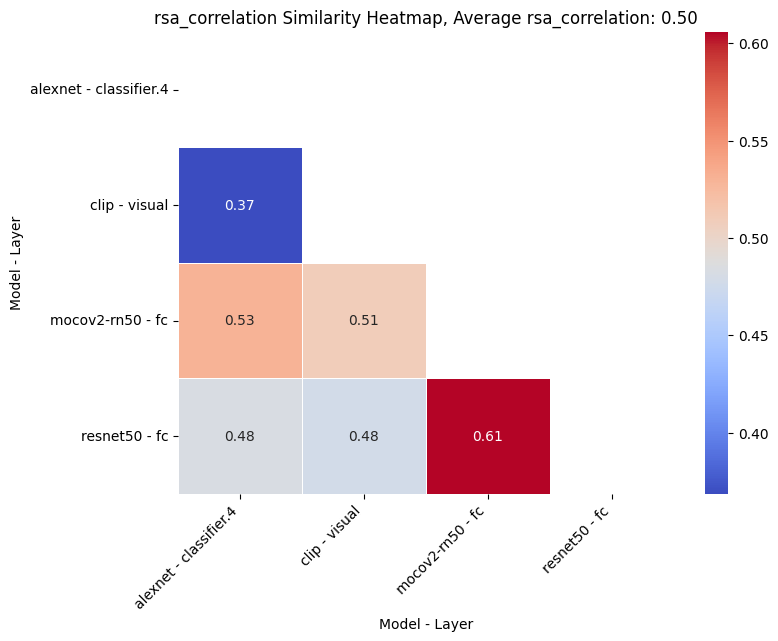

In [7]:
# RSA 
rsa_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'rsa_correlation'])

# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        
        # Apply PCA to reduce to 20 features
        pca1 = PCA(n_components=20)
        pca2 = PCA(n_components=20)
        
        features_1_pca = pca1.fit_transform(features_1)
        features_2_pca = pca2.fit_transform(features_2)
        
        # Compute RDMs for both feature sets
        rdm1 = compute_rdm(features_1_pca, method='correlation')
        rdm2 = compute_rdm(features_2_pca, method='correlation')
        
        # Correlate the RDMs
        correlation = correlate_rdms(rdm1, rdm2, correlation='pearson')
        
        # Add to dataframe
        rsa_df.loc[len(rsa_df)] = [model1['model_name'], model2['model_name'], 
                                    layer1, layer2, correlation]
        
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')

# Plot the results
plot_similarity_heatmap(df=rsa_df, metric='rsa_correlation')

## CKA (Centered Kernel Alignment)

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
cka


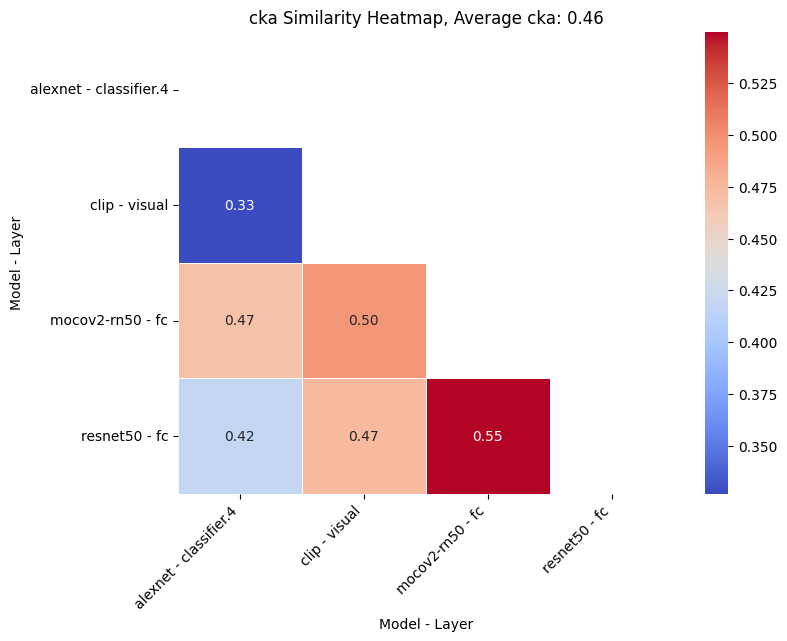

In [5]:

# cka 
cka_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'cka'])
# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        
        # # Apply PCA to reduce to 20 features
        pca1 = PCA(n_components=20)
        pca2 = PCA(n_components=20)
        
        features_1_pca = pca1.fit_transform(features_1)
        features_2_pca = pca2.fit_transform(features_2)
        
        # # Compute RDM on PCA-reduced features
        # rdm1 = compute_rdm(features_1_pca, method='cosine')
        # rdm2 = compute_rdm(features_2_pca, method='cosine')
        # Calculate CKA
        # assert rdm1.shape == rdm2.shape
        m = features_1.shape[0]
        cka = CKA(m=m, kernel='linear')
        rho = cka.compare(X=features_1_pca, Y=features_2_pca)
        # Add to dataframe
        cka_df.loc[len(cka_df)] = [model1['model_name'], model2['model_name'], 
                                   layer1, layer2, rho]
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')
plot_similarity_heatmap(df = cka_df, metric = 'cka')

## Procestes correlation

Completed 1/6 comparisons
Completed 2/6 comparisons
Completed 3/6 comparisons
Completed 4/6 comparisons
Completed 5/6 comparisons
Completed 6/6 comparisons
procrustes_correlation


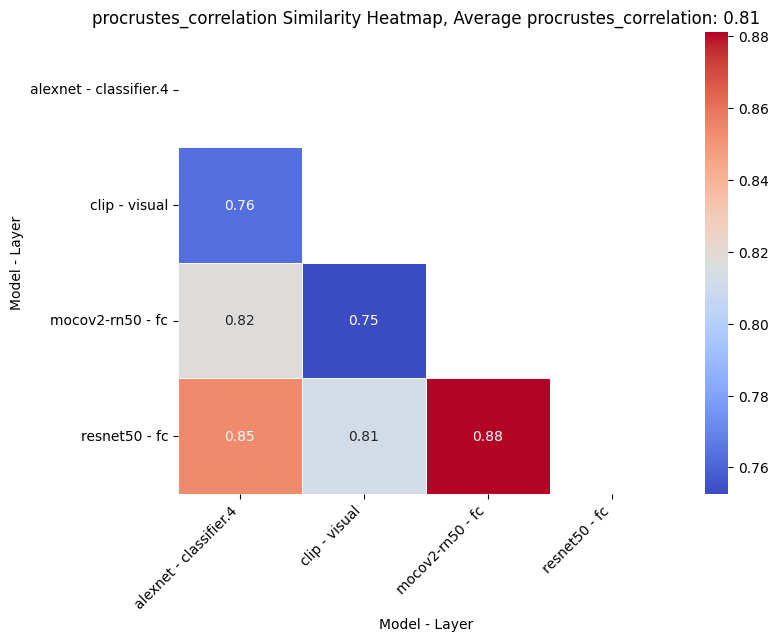

In [ ]:
# Procrustes Analysis

procrustes_df = pd.DataFrame(columns=['model1', 'model2', 'layer1', 'layer2', 'procrustes_correlation'])

# Combinations of models (no repeats)
for i, (model1, model2) in enumerate(list(combinations(models, 2))):
    # Product of layers for each model pair
    for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
        features_1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
        features_2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
        fnames = np.loadtxt(f'{activation_dir}/{dataset_name}/file_names.txt', dtype=str)
        # Extract class names from file paths
        class_names = [f.split('/')[-2] for f in fnames]
        unique_classes = np.unique(class_names)
        
        
        # Calculate mean representation for each class
        mean_features_1 = {}
        mean_features_2 = {}
        
        for class_name in unique_classes:
            class_indices = [i for i, c in enumerate(class_names) if c == class_name]
            mean_features_1[class_name] = np.mean(features_1[class_indices], axis=0)
            mean_features_2[class_name] = np.mean(features_2[class_indices], axis=0)
            
        # Convert to matrices for Procrustes analysis
        class_means_1 = np.array([mean_features_1[c] for c in unique_classes])
        class_means_2 = np.array([mean_features_2[c] for c in unique_classes])
        
        # Compute rdms
        rdm1 = compute_rdm(class_means_1, method='cosine')
        rdm2 = compute_rdm(class_means_2, method='cosine')
        
        # Compute Procrustes disparity
        _, _, disparity = procrustes(rdm1, rdm2)
        
        # Convert disparity to correlation
        correlation = np.sqrt(1 - disparity)
        
        # Add to dataframe
        procrustes_df.loc[len(procrustes_df)] = [model1['model_name'], model2['model_name'], 
                              layer1, layer2, correlation]
        
        print(f'Completed {i+1}/{len(list(combinations(models, 2)))} comparisons')
        

plot_similarity_heatmap(df=procrustes_df, metric='procrustes_correlation')

## Most similar models
 We find that moco and resnet40 are the most similar models according to all three metrics. We can then create a json file with the names of the models that are most similar to each other.


In [ ]:
# Let's export the json file for submission
# The json file should contain the information about the models used in the analysis, this would include the model name, source, and model parameters needed to load the model.
models = [{'model_name':'resnet50', 'source':'torchvision', 'model_parameters':None},
          {'model_name':'mocov2-rn50', 'source':'ssl', 'model_parameters':None}]

models_json = {'models': models}

if not os.path.exists('blue_team_submission'):
    os.makedirs('blue_team_submission')
with open('blue_team_submission/models.json', 'w') as f:
    json.dump(models_json, f)

# Find images that maximally differentiate between models

## Helper functions

In [28]:
def compare_random_image_groups(activation_dir, dataset_name, models, num_groups=5, images_per_group=20, methods=None):
    """
    Compare random groups of images using different alignment metrics.
    """
    # Load file names
    fnames = np.loadtxt(f'{activation_dir}/{dataset_name}/file_names.txt', dtype=str)
    
    # Default methods if not specified
    if methods is None:
        methods = ['cka', 'rsa', 'procrustes']
        
    # Create random groups
    random.seed(42)
    num_images = len(fnames)
    groups = {}
    for i in range(num_groups):
        groups[i] = np.array(random.sample(range(num_images), images_per_group))
    
    # Initialize results dictionary
    results = {method: np.zeros(num_groups) for method in methods}
    
    # For each model pair, compute alignment metrics for each group
    for method in methods:
        metric_values = []
        
        for idx, (model1, model2) in enumerate(combinations(models, 2)):
            print(f"Processing model pair for {method}: {model1['model_name']} vs {model2['model_name']}")
            
            for layer1, layer2 in product(model1['layers_to_extract'], model2['layers_to_extract']):
                features1 = np.load(f'{activation_dir}/{dataset_name}/{model1["model_name"]}/{layer1}/features.npy')
                features2 = np.load(f'{activation_dir}/{dataset_name}/{model2["model_name"]}/{layer2}/features.npy')
                
                # Apply PCA if needed
                if features1.shape[1] > 50:
                    pca1 = PCA(n_components=50)
                    pca2 = PCA(n_components=50)
                    features1 = pca1.fit_transform(features1)
                    features2 = pca2.fit_transform(features2)
                
                # Calculate metric for each group
                group_metrics = np.zeros(num_groups)
                
                for i in range(num_groups):
                    group_idx = groups[i]
                    
                    # Extract features for this group
                    group_features1 = features1[group_idx]
                    group_features2 = features2[group_idx]
                    
                    # Compute metric for this group
                    if method == 'cka':
                        cka = CKA(m=len(group_idx), kernel='linear')
                        similarity = cka.compare(X=group_features1, Y=group_features2)
                        group_metrics[i] = similarity
                        
                    elif method == 'rsa':
                        rdm1 = compute_rdm(group_features1, method='correlation')
                        rdm2 = compute_rdm(group_features2, method='correlation')
                        correlation = correlate_rdms(rdm1, rdm2, correlation='pearson')
                        group_metrics[i] = correlation  
                        
                    elif method == 'procrustes':
                        rdm1 = compute_rdm(group_features1, method='cosine')
                        rdm2 = compute_rdm(group_features2, method='cosine')
                        _, _, disparity = procrustes(rdm1, rdm2)
                        group_metrics[i] = np.sqrt(1-disparity**2)  # Convert to correlation
                
                metric_values.append(group_metrics)
        
        # Average across all model pairs
        results[method] = np.mean(np.array(metric_values), axis=0)
    
    return groups, results, fnames


def rank_groups_by_dissimilarity(results):
    """
    Rank groups by dissimilarity for each metric.
    """
    rankings = {}
    
    for method, scores in results.items():
        # Sort by dissimilarity (high to low)
        sorted_indices = np.argsort(scores)
        
        # Create ranking dictionary
        method_rankings = {}
        for rank, idx in enumerate(sorted_indices):
            method_rankings[idx] = {
                'rank': rank + 1,
                'score': scores[idx]
            }
        
        rankings[method] = method_rankings
    
    return rankings


def visualize_results(groups, results, rankings, fnames, output_dir):
    """
    Visualize results and sample images from each group.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create summary plot
    fig = plt.figure(figsize=(15, 4 * len(groups)))
    gs = GridSpec(len(groups), 5, figure=fig)  # 5 sample images per group
    
    for group_id, image_indices in groups.items():
        # Create ranking info string
        ranking_info = " | ".join([
            f"{method.upper()}: {results[method][group_id]:.3f} (Rank: {rankings[method][group_id]['rank']})"
            for method in results.keys()
        ])
        
        # Select sample images
        sample_indices = random.sample(list(image_indices), min(5, len(image_indices)))
        
        for i, img_idx in enumerate(sample_indices):
            img_path = fnames[img_idx]
            try:
                img = Image.open(img_path)
                ax = fig.add_subplot(gs[group_id, i])
                ax.imshow(img)
                if i == 0:
                    ax.set_title(f"Group {group_id}\n{ranking_info}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/group_comparison.png", dpi=300)
    plt.close(fig)
    
def visualize_results(groups, results, rankings, fnames, output_dir):
    """
    Visualize results and sample images from each group.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create summary plot
    fig = plt.figure(figsize=(15, 4 * len(groups)))
    gs = GridSpec(len(groups), 5, figure=fig)  # 5 sample images per group
    
    for group_id, image_indices in groups.items():
        # Create ranking info string
        ranking_info = " | ".join([
            f"{method.upper()}: {results[method][group_id]:.3f} (Rank: {rankings[method][group_id]['rank']})"
            for method in results.keys()
        ])
        
        # Select sample images
        sample_indices = random.sample(list(image_indices), min(5, len(image_indices)))
        
        for i, img_idx in enumerate(sample_indices):
            img_path = fnames[img_idx]
            try:
                img = Image.open(img_path)
                ax = fig.add_subplot(gs[group_id, i])
                ax.imshow(img)
                if i == 0:
                    ax.set_title(f"Group {group_id}\n{ranking_info}", fontsize=10)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    plt.tight_layout()
    # plt.savefig(f"{output_dir}/group_comparison.png", dpi=300)
    plt.show()
    plt.close(fig)
    
    # Create bar chart for dissimilarity rankings
    methods = list(results.keys())
    fig, axes = plt.subplots(len(methods), 1, figsize=(10, 3 * len(methods)))
    
    for i, method in enumerate(methods):
        scores = results[method]
        ax = axes[i] if len(methods) > 1 else axes
        ax.bar(range(len(scores)), scores)
        ax.set_title(f"{method.upper()}")
        ax.set_xticks(range(len(scores)))
        ax.set_xticklabels([f"Group {j} (Rank {rankings[method][j]['rank']})" for j in range(len(scores))])
    
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{output_dir}/dissimilarity_rankings.png", dpi=300)
    plt.close(fig)

## Finding a group of 20 random images that maximally differentiate between models

In [ ]:
activation_dir = '../activations'
dataset_name = 'cifar100'
output_dir = './red_team_submission'

# Define models
models = [
    {'model_name': 'resnet50', 'source': 'torchvision', 'model_parameters': None, 'layers_to_extract': ['fc']},
    {'model_name': 'mocov2-rn50', 'source': 'ssl', 'model_parameters': None, 'layers_to_extract': ['fc']},
    {'model_name': 'clip', 'source': 'custom', 'model_parameters': {'variant': 'ViT-B/32'}, 'layers_to_extract': ['visual']},
    {'model_name': 'alexnet', 'source': 'torchvision', 'model_parameters': None, 'layers_to_extract': ['classifier.4']}
]

methods = ['cka', 'rsa', 'procrustes']

In [29]:
# Compare random image groups
# We randomly sample 5 groups of 20 images each
# and compare how the models align on these groups 
# using CKA, RSA, and Procrustes analysis
groups, results, fnames = compare_random_image_groups(
        activation_dir, dataset_name, models, 
        num_groups=5, images_per_group=20,
        methods=methods
    )

Processing model pair for cka: resnet50 vs mocov2-rn50
Processing model pair for cka: resnet50 vs clip
Processing model pair for cka: resnet50 vs alexnet
Processing model pair for cka: mocov2-rn50 vs clip
Processing model pair for cka: mocov2-rn50 vs alexnet
Processing model pair for cka: clip vs alexnet
Processing model pair for rsa: resnet50 vs mocov2-rn50
Processing model pair for rsa: resnet50 vs clip
Processing model pair for rsa: resnet50 vs alexnet
Processing model pair for rsa: mocov2-rn50 vs clip
Processing model pair for rsa: mocov2-rn50 vs alexnet
Processing model pair for rsa: clip vs alexnet
Processing model pair for procrustes: resnet50 vs mocov2-rn50
Processing model pair for procrustes: resnet50 vs clip
Processing model pair for procrustes: resnet50 vs alexnet
Processing model pair for procrustes: mocov2-rn50 vs clip
Processing model pair for procrustes: mocov2-rn50 vs alexnet
Processing model pair for procrustes: clip vs alexnet


In [30]:
rankings = rank_groups_by_dissimilarity(results)
rankings

{'cka': {4: {'rank': 1, 'score': 0.6393085449142378},
  3: {'rank': 2, 'score': 0.6798207590512558},
  2: {'rank': 3, 'score': 0.6916000862881383},
  0: {'rank': 4, 'score': 0.6986826805989632},
  1: {'rank': 5, 'score': 0.7046206976130164}},
 'rsa': {4: {'rank': 1, 'score': 0.42526867596076223},
  0: {'rank': 2, 'score': 0.47223058072322516},
  1: {'rank': 3, 'score': 0.48813086634109687},
  3: {'rank': 4, 'score': 0.5226664104970511},
  2: {'rank': 5, 'score': 0.5372023168454986}},
 'procrustes': {4: {'rank': 1, 'score': 0.8992905387671791},
  3: {'rank': 2, 'score': 0.9256249229697907},
  0: {'rank': 3, 'score': 0.9262715902724369},
  2: {'rank': 4, 'score': 0.9315744047030702},
  1: {'rank': 5, 'score': 0.9354193442696915}}}

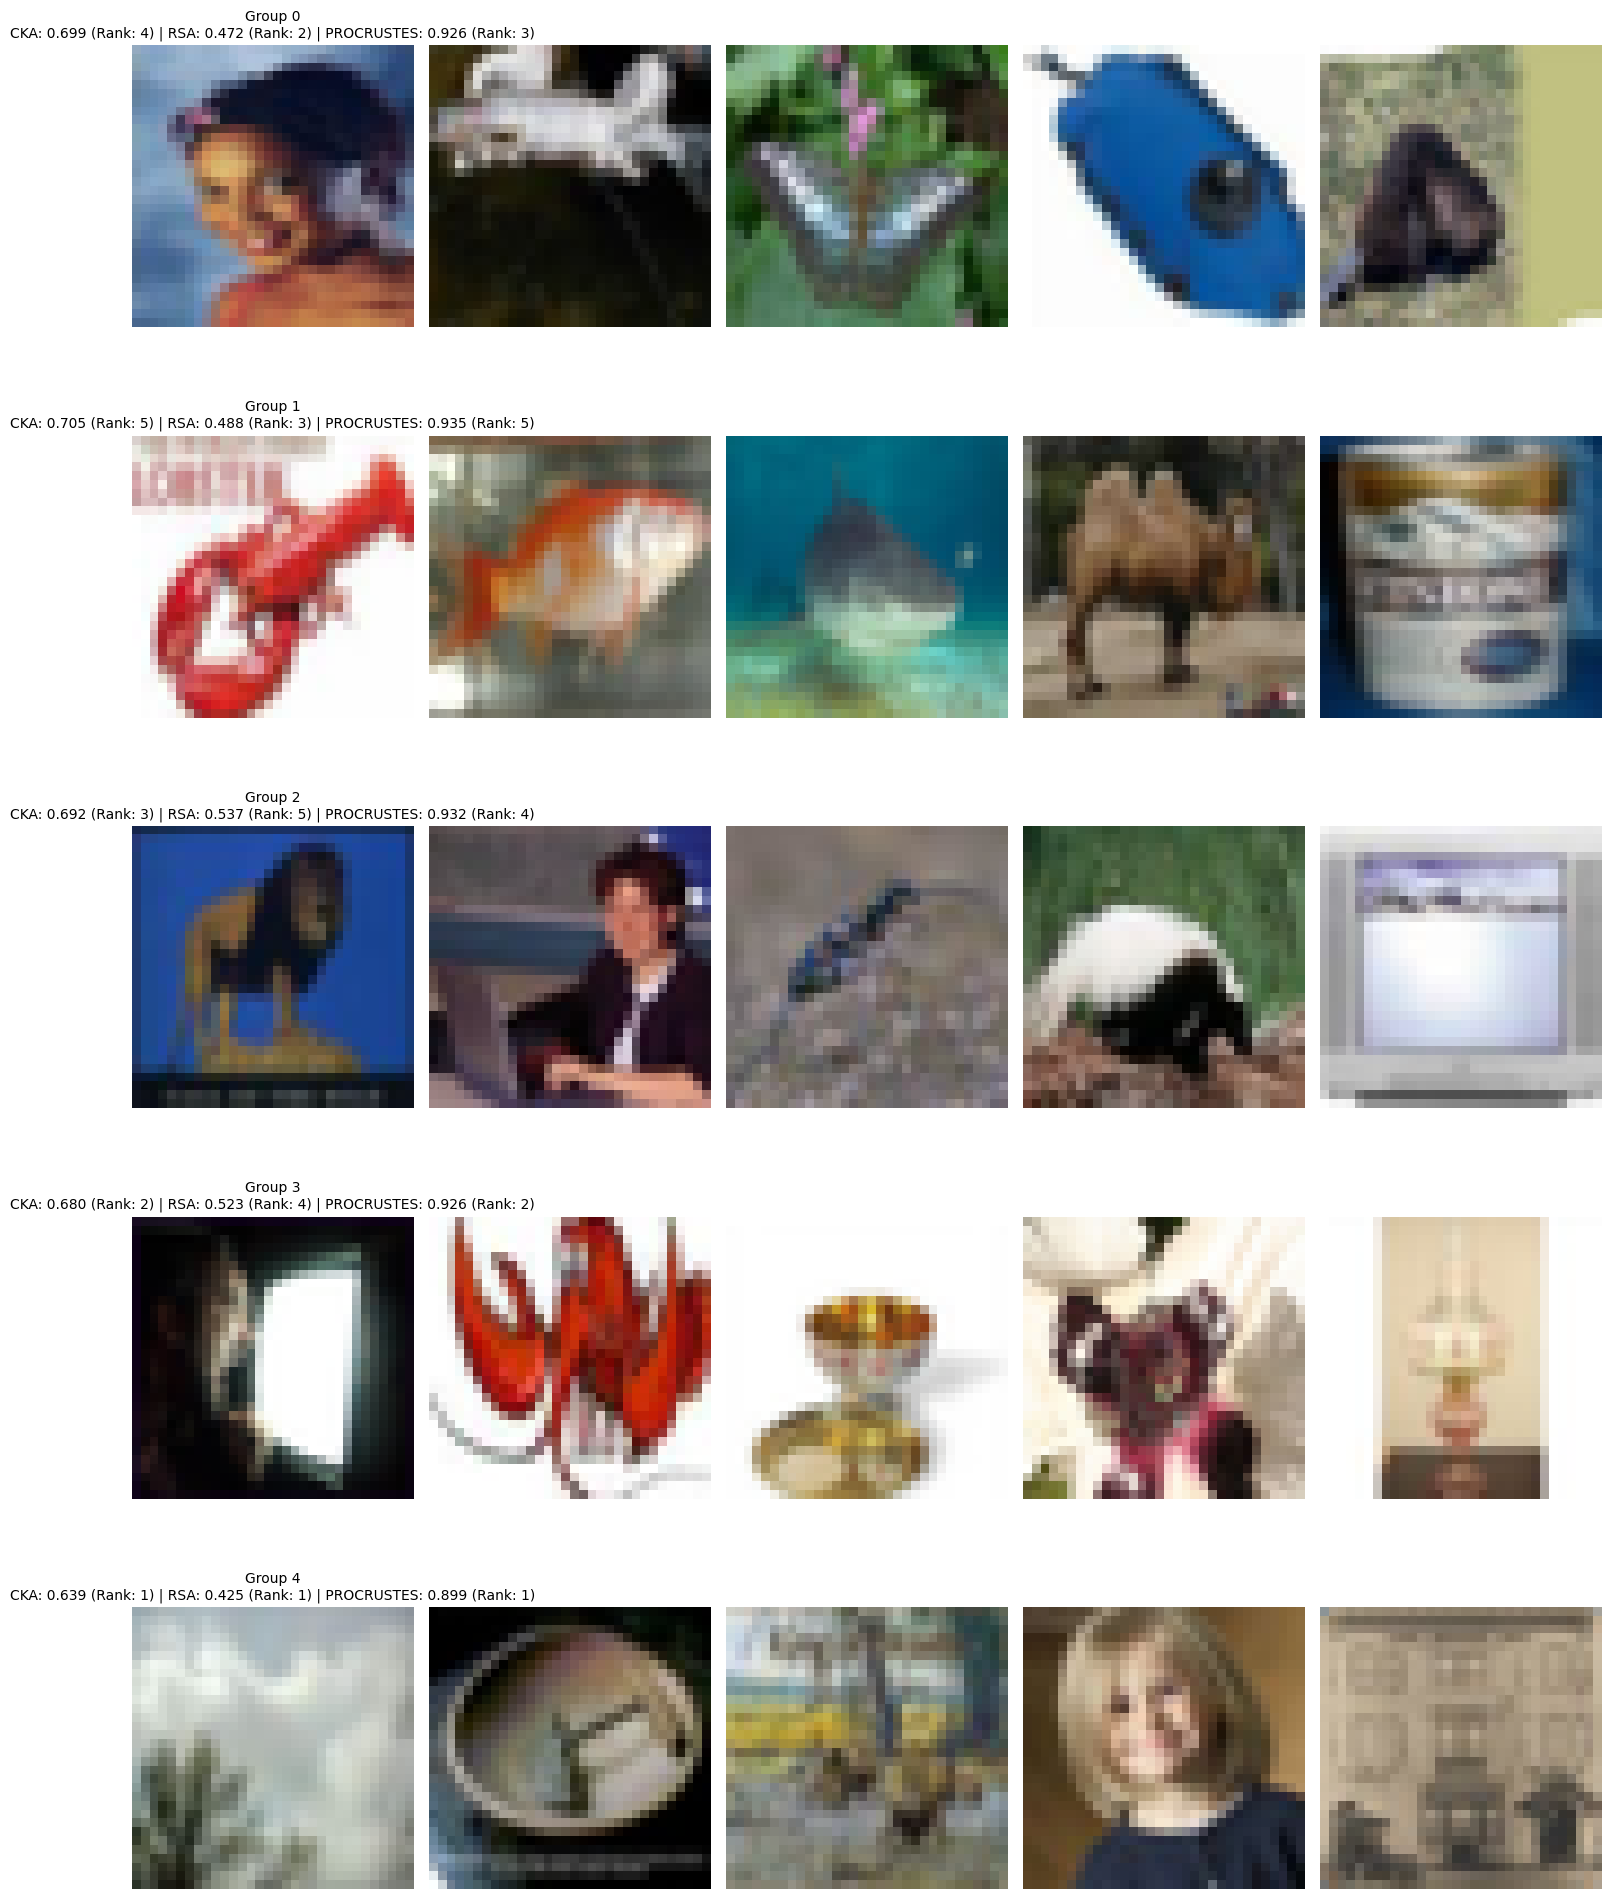

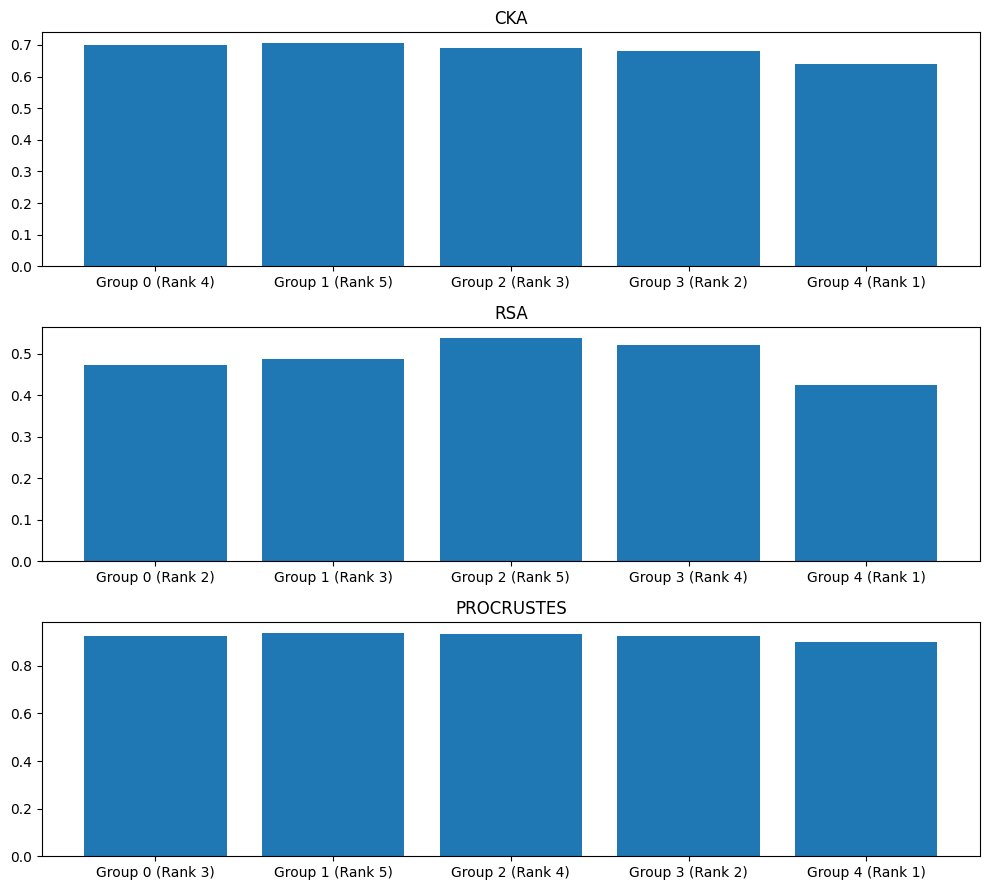

In [31]:
# this shows the results of the comparison
# and a subset of  images in each group
visualize_results(groups, results, rankings, fnames, output_dir)

In [32]:
# from the rankings, we find the group that maximizes the difference between the models
# first we score the groups based on the rankings
# for each metric a group gets a score of 5 if it is the best, 4 if it is the second best and so on
group_scores = {i: 0 for i in range(5)}
for method in rankings.keys():
    for group_id, rank_info in rankings[method].items():
        score = 5 - rank_info['rank']
        group_scores[group_id] += score
        
# the group with the highest score is the one that maximizes the difference between the models
best_group = max(group_scores, key=group_scores.get)
best_group


4

In [33]:
# we find that group 4 maximizes the difference between the models
# we can now crate a zip file with the images in this group

import zipfile

# Create a zip file with the images in the best group
with zipfile.ZipFile(f"{output_dir}/best_group_images.zip", "w") as zf:
    for img_idx in groups[best_group]:
        img_path = fnames[img_idx]
        zf.write(img_path, os.path.basename(img_path))